# Spectral method for a  Hugget model with two incomes - Weakly binding credit constraint

In [1]:
%run 'backend.ipynb'
backend_test_function()

Backend import successful! - 2022-08-27 16:58:55.495096


# Economic parameters

In [2]:
gamma = 1.2 # CRRA utility parameter
def u(x): return x**(1-gamma) / (1-gamma) # Utility function
def du(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility
rho = 0.05 # Discount rate

r = 0.035 # Interest rate

zlow, zhigh = 0.1, 0.2 # High, low income states
z = np.array([zlow, zhigh])

lambda1, lambda2 = 1.5, 1. # Low->high, high->low transition rates
G = np.array([[-lambda1, lambda1], [lambda2, -lambda2]]) # Generator / transition rate matrix

amin, amax = -zlow/r + 0.05, 3.
print('amin:', amin)

amin: -2.8071428571428574


## Numerical parameters

In [3]:
maxiter = 1000
crit = 1e-10

# Hamilton-Jacobi-Bellman Equation

## Finite differences

In [4]:
# Numerical parameters
I = 500
a_fd = np.linspace(amin, amax, I)
da_fd = (amax-amin)/(I-1)

aa_fd = np.tile(a_fd,(2,1))
zz_fd = np.tile(z,(I,1)).T

delta = 2000.

In [5]:
# Initial guess
v0_fd = u(r*aa_fd + zz_fd)/rho

# Transition matrix
z_transition = sparse.kron(G,sparse.eye(I), format='csr')

# Initialization
v_old = np.zeros((2,I))
g = np.zeros((2,I))
dv = np.zeros((2,I-1))
cf = np.zeros((2,I-1))
c0 = np.zeros((2,I))
ssf = np.zeros((2,I))
ssb = np.zeros((2,I))
is_backward = np.zeros((2,I))
is_forward = np.zeros((2,I))
diag_helper = np.zeros((2,I))        
A = z_transition.copy()
B = z_transition.copy()

In [6]:
v_fd = v0_fd.copy()

for i in range(maxiter):
            
    dv = (v_fd[:,1:]-v_fd[:,:-1])/da_fd
    cf = du_inv(dv)
    c0 = r*aa_fd + zz_fd
    
    ssf[:,:-1] = c0[:,:-1]-cf
    ssb[:,1:] = c0[:,1:]-cf

    is_backward = ssf>0
    is_forward = ssb<0
    
    c0[:,:-1] += (cf-c0[:,:-1])*is_backward[:,:-1]
    c0[:,1:] += (cf-c0[:,1:])*is_forward[:,1:]
    
    A = z_transition.copy()
    diag_helper = (-ssf*is_backward/da_fd + ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper,0,2*I,2*I)
    diag_helper = (-ssb*is_forward/da_fd).flatten()
    A += sparse.spdiags(diag_helper[1:],-1,2*I,2*I)
    diag_helper = (ssf*is_backward/da_fd).flatten()
    A += sparse.spdiags(np.hstack((0,diag_helper)),1,2*I,2*I)
    
    B = sparse.eye(2*I)*(1/delta + rho) - A
    b = u(c0).reshape(-1,1) + v_fd.reshape(-1,1)/delta
    A_fd, v_old, s_fd = A.copy(), v_fd.copy(), (r*aa_fd + zz_fd - c0)
    v_fd = spsolve(B,b).reshape(2,I)

    dist = np.max(np.abs(v_old-v_fd))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 10  - Last distance: 1.7962520360015333e-11  - Last delta: 2000.0


In [7]:
zz_fd, aa_fd = zz_fd.flatten(), aa_fd.flatten()
v_fd, s_fd = v_fd.flatten(), s_fd.flatten()

## Spectral method

In [8]:
N = 200

a_sp, [Da] = dm.chebdif(N, 1)
a_sp, [Da] = rescale_nodes_and_derivatives(a_sp, [Da], left=amin, right=amax)

aa_sp = np.tile(a_sp, 2)
zz_sp = np.repeat(z, N)

# Differentiation matrix w.r.t. a
D_a = np.kron(np.eye(2), Da)

# Switching matrix
GG = np.kron(G,np.eye(N))

# Initial guess
v0_sp = u(zz_sp+r*aa_sp)/rho

In [9]:
v_sp = v0_sp.copy()

for i in range(maxiter):
    
    delta = np.exp(i)
    
    dv = D_a@v_sp
    c = du_inv(dv)
    s_sp = zz_sp + r*aa_sp - c
    
    A = s_sp.reshape(-1,1)*D_a + GG
    B = (1/delta + rho)*np.eye(2*N) - A
    b = u(c) + v_sp/delta
    
    B[0] = D_a[0]
    b[0] = du(zz_sp + r*aa_sp)[0]
    
    v_old = v_sp.copy()
    v_sp = np.linalg.solve(B,b)
    
    dist = np.max(np.abs(v_old-v_sp))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 12  - Last distance: 4.888534022029489e-12  - Last delta: 59874.14171519782


# Kolmogorov Forward Equation

## Helpers

In [10]:
def normalize_distribution(g, a, method='interpolation'):
    if method=='finite':
        da = np.hstack([np.diff(a),0,np.diff(a),0]) #CCC
        return g/np.sum(g*da)
    elif method=='interpolation':
        mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        return g / (mass_low + mass_high)
    elif method=='mixed':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        return g / (dirac_mass_low + density_mass_low + dirac_mass_high + density_mass_high)
    else: sys.exit('Method not recognized!')

def solve_zero_eigenvector(C, a, disp=False):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1)
    assert np.isreal(l) and np.isreal(g).all(), "Zero-eigenvector is complex"
    l, g = float(np.real(l)), np.real(g).flatten()
    if disp: print('l:', l)
    return g

def solve_minimal_positive_vector(C, a=a_sp, disp=True, g0=None):
    error = lambda x: np.linalg.norm(C@x)**2
    jac_error = lambda x: 2*(C.T@C)@x
    g0 = np.ones(len(C))
    bounds = sp.optimize.Bounds(0, np.inf)
    res = sp.optimize.minimize(error, g0, method='SLSQP', bounds=bounds, jac=jac_error, options={'maxiter':1000, 'ftol':1e-12})
    if disp: print('e:', res.fun)
    g = normalize_distribution(res.x, a=a)
    return g

def compute_g(C, a=a_sp, method='auto', normalize_method='finite', negtol=-1e-6):
    if method=='eigs': g = solve_zero_eigenvector(C, a=a)
    elif method=='minimize': g = solve_minimal_positive_vector(C, a=a)
    elif method=='auto':
        g = solve_zero_eigenvector(C, a=a)
        if (g<negtol).any(): g = solve_minimal_positive_vector(C, a=a)
    else: sys.exit('Method not recognized!')
    g = normalize_distribution(g, a, normalize_method)
    return g

In [11]:
def compute_g_moments(g, a, method=None):
    
    assert len(a) == len(g)/2
    g_assets = (g[:len(a)]+g[len(a):])
        
    if method=='finite':
        da = np.hstack([np.diff(a),0]) #CCC
        dirac_mass_low = g[0]*da[0]
        density_mass_low = np.sum(g[1:len(a)]*da[1:]) # CCC: there has to be a better way...
        dirac_mass_high = g[len(a)]*da[0]
        density_mass_high = np.sum(g[len(a)+1:]*da[1:])
        K = np.sum(g_assets*a*da)
        CDF = (g_assets*da).cumsum()
        gini = (1/K) * np.sum(da*CDF*(1-CDF))
        D1, Q1, Q3, D9 = np.interp([0.1,0.25,0.75,0.9],(da*g_assets).cumsum(),a)
    
    elif method=='interpolation':
        dirac_mass_low = np.nan
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a, g[:len(a)]).integral(a[0], a[-1])
        dirac_mass_high = np.nan
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a, g[len(a):]).integral(a[0], a[-1])
        K = sp.interpolate.InterpolatedUnivariateSpline(a, g_assets*a).integral(a[0], a[-1])
        g_assets = g_assets / sp.interpolate.CubicSpline(a, g_assets).integrate(a[0], a[-1])
        CDF_assets_ppoly = sp.interpolate.CubicSpline(a, g_assets).antiderivative()
        CDF_assets = CDF_assets_ppoly(a_sp)
        CDF_assets_quantile = lambda q: CDF_assets_ppoly.solve(q, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a, CDF_assets*(1-CDF_assets)).integrate(a[0], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9) 
        
    elif method=='mixed':
        dirac_mass_low = g[0]*(a[1]-a[0])
        density_mass_low = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[1:len(a)]).integral(a[1], a[-1])
        dirac_mass_high = g[len(a)]*(a[1]-a[0])
        density_mass_high = sp.interpolate.InterpolatedUnivariateSpline(a[1:], g[len(a)+1:]).integral(a[1], a[-1])
        K = a[0]*g_assets[0]*(a[1]-a[0]) + sp.interpolate.InterpolatedUnivariateSpline(a[1:], g_assets[1:]*a[1:]).integral(a[1], a[-1])
        dirac_mass = dirac_mass_low + dirac_mass_high
        g_assets = g_assets / (dirac_mass + sp.interpolate.CubicSpline(a[1:], g_assets[1:]).integrate(a[1], amax))
        CDF_assets_trunc_ppoly = sp.interpolate.CubicSpline(a[1:], g_assets[1:]).antiderivative()
        CDF_assets_trunc = CDF_assets_trunc_ppoly(a[1:])+dirac_mass
        CDF_assets_quantile = lambda q: (q<=dirac_mass)*a[0] + (dirac_mass<q)*CDF_assets_trunc_ppoly.solve(q-dirac_mass, extrapolate=False).mean()
        gini = (1/K) * sp.interpolate.CubicSpline(a[1:], CDF_assets_trunc*(1-CDF_assets_trunc)).integrate(a[1], a[-1])
        D1, Q1, Q3, D9 = CDF_assets_quantile(0.1), CDF_assets_quantile(0.25), CDF_assets_quantile(0.75), CDF_assets_quantile(0.9)
    
    else: sys.exit('Method not recognized!')
    
    return np.array([dirac_mass_low, density_mass_low, dirac_mass_high, density_mass_high, K, gini, D1, Q1, Q3, D9])

In [12]:
def plot_g(g, a, title='', filename='', interp=False, symlog=False, moment_method=None):
        
    fig, ax = plt.subplots(figsize=(5,5))
    

    ax.plot(a, g[:len(a)], 'C0.-', label='High-income')
    ax.plot(a, g[len(a):], 'C1.-', label='High-income')
    
    ax.set_title(title)
    ax.legend(loc='upper right', frameon=False)
    
    #ax.set_ylim([-0.1, 2.6])
    #ax.set_xlim([-3.1, 0.1])

    plt.tight_layout()
    savefig(ax, filename)
    
    K, gini = compute_g_moments(g, a, method=moment_method)[[4,5]]
    
    print('K:', K)
    print('Gini:', gini)

## Finite Differences

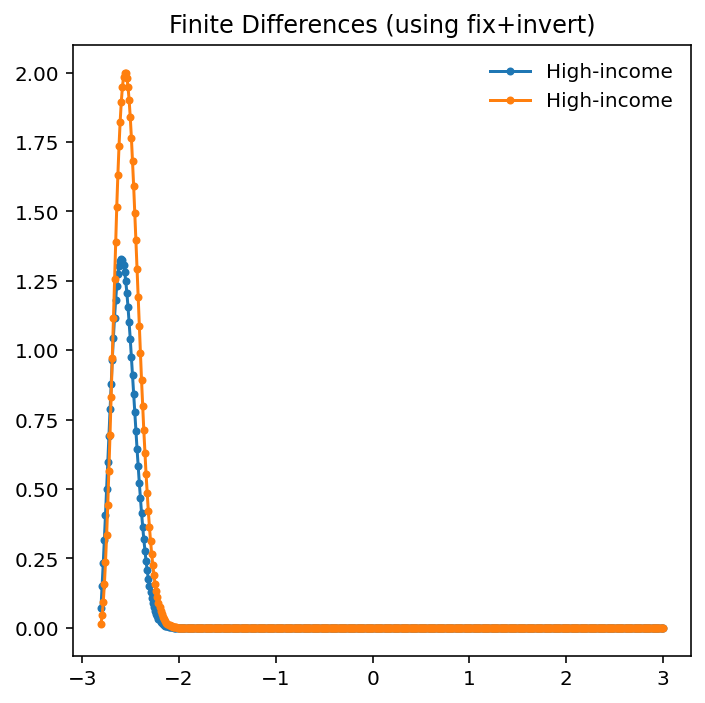

Saved to: two_state_weakly_binding_density_finite_differences.pdf
K: -2.544712882355161
Gini: -0.026350924605069385


In [13]:
AT_fd = A_fd.T.tocsr()
AT_fd.data[1:AT_fd.indptr[1]] = 0
AT_fd.data[0] = 1.
AT_fd.indices[0] = 0
AT_fd.eliminate_zeros()

b = np.zeros((2*I,1))
b[0] = 1.

g_fd = spsolve(AT_fd,b)
g_fd = g_fd/(da_fd*g_fd.sum())

plot_g(g_fd, a_fd, 'Finite Differences (using fix+invert)', 'two_state_weakly_binding_density_finite_differences', moment_method='finite')

## Fully Spectral

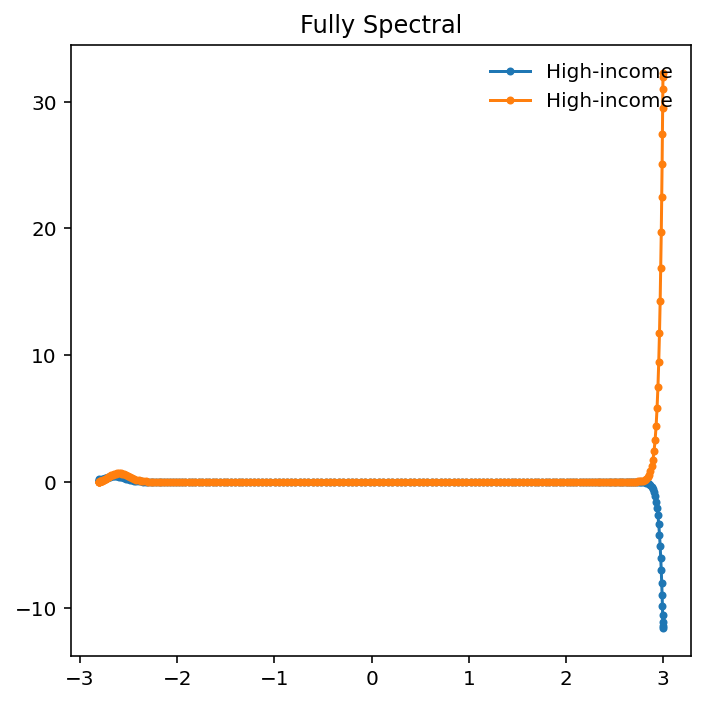

Saved to: two_state_weakly_binding_density_fully_spectral_eigs.pdf
K: 1.4857307796610022
Gini: 0.7400502625605077
e: 1.6631971649100135e-08


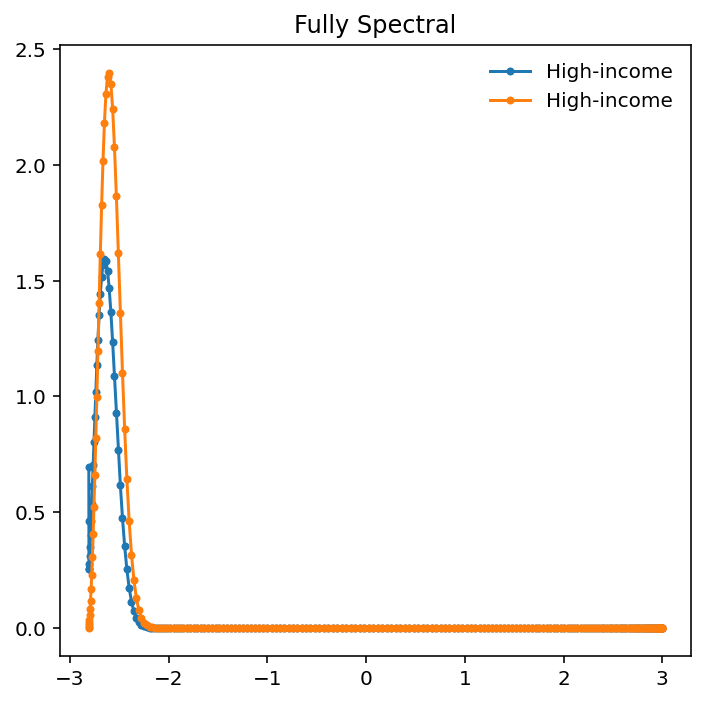

Saved to: two_state_weakly_binding_density_fully_spectral.pdf
K: -2.5948970156808167
Gini: -0.022130068358295427


In [14]:
C_fully_spectral = -D_a*s_sp.flatten() + GG.T

g_fully_spectral_eigs = compute_g(C_fully_spectral, a_sp, method='eigs', normalize_method='interpolation')
plot_g(g_fully_spectral_eigs, a_sp, 'Fully Spectral', 'two_state_weakly_binding_density_fully_spectral_eigs', interp=True, moment_method='interpolation')

g_fully_spectral = compute_g(C_fully_spectral, a_sp, method='minimize', normalize_method='interpolation')
plot_g(g_fully_spectral, a_sp, 'Fully Spectral', 'two_state_weakly_binding_density_fully_spectral', interp=True, moment_method='interpolation')